In [1]:
import nasdaqdatalink as quandl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date, timedelta
from common import date_util
from data import investment_universe, sharadar_fundamentals, sharadar_prices, sharadar_tickers
from signals import fundamental_signal

In [2]:
quandl.ApiConfig.api_key = 'NRvcyMwNMXZ2ooDSM3nw'
factor_summary = {}
factor_list = ["accruals", "debt_to_equity", "net_profit_margin", "return_on_equity", #"gross_margin", "margin", "operating_margin", "operating_leverage",  "return_on_invcap",
               "book_to_price", "dividend_yield", "earnings_yield", "fcf_to_ev", "fcf_yield",
               "fcf_to_ic_growth",
               "size"]#, "ncfo_to_ev", "ncfo_to_mc", "ncf_to_ev", "ncf_to_mc", "sales_to_price", "tangible_asset_to_price"]

In [3]:
for factor in factor_list:
    pnl = []
    sector_level_pnl = {}
    rebal_date = date(1999, 1, 1)
    while rebal_date <= date(2019, 12, 31):
        rebal_date = date_util.get_next_rebal_day(rebal_date, 3)

        universe = investment_universe.get_SPX(rebal_date)
        fundamentals = sharadar_fundamentals.get_fundamentals(universe['ticker'].to_list(), rebal_date)
        p_fundamentals = sharadar_fundamentals.get_fundamentals(universe['ticker'].to_list(), rebal_date - timedelta(weeks=52))
        prices = sharadar_prices.get_prices(universe['ticker'].to_list(), rebal_date)
        price_df = prices[["ticker", "forward_return"]]
        sectors = sharadar_tickers.get_tickers(universe['ticker'].to_list(), rebal_date)
        sectors = sectors[["ticker", "sector", "industry"]]

        fundamentals = pd.merge(fundamentals, sectors, left_on="ticker", right_on="ticker", how="inner")
        fundamentals = pd.merge(fundamentals, price_df, left_on="ticker", right_on="ticker", how="inner")
        fundamentals = pd.merge(fundamentals, p_fundamentals, left_on="ticker", right_on="ticker", how="inner", suffixes=["", "_1y"])
        fundamentals.loc[fundamentals["sector"] == "Real Estate", "sector"] = "Financial Services"
        func = getattr(fundamental_signal, factor)
        fundamentals = func(fundamentals)
        fundamentals = fundamentals[~fundamentals[factor].isna()]
        fundamentals["composite"] = fundamentals.groupby("sector", group_keys=False)[factor].apply(lambda x: (x - np.mean(x)) / np.std(x))

        fundamentals = fundamentals.sort_values("composite", ascending=False)
        fundamentals = fundamentals[~fundamentals["sector"].isin(["Real Estate"])]
        pnl.append(fundamentals[fundamentals["composite"] >= fundamentals.groupby("sector")["composite"].transform("quantile", 0.75)]["forward_return"].mean() - 
                fundamentals[fundamentals["composite"] <= fundamentals.groupby("sector")["composite"].transform("quantile", 0.25)]["forward_return"].mean())
        longs = fundamentals[fundamentals["composite"] >= fundamentals.groupby("sector")["composite"].transform("quantile", 0.8)].groupby("sector").agg({"forward_return": "sum", "ticker": "count"})
        shorts = fundamentals[fundamentals["composite"] <= fundamentals.groupby("sector")["composite"].transform("quantile", 0.2)].groupby("sector").agg({"forward_return": "sum", "ticker": "count"})
        sector_pnl = pd.merge(longs, shorts, left_index=True, right_index=True, suffixes=["_l", "_s"])
        sector_pnl["forward_return"] = sector_pnl["forward_return_l"] / sector_pnl["ticker_l"] - sector_pnl["forward_return_s"] / sector_pnl["ticker_s"]
        sector_level_pnl[rebal_date] = sector_pnl["forward_return"].to_list()

    sector_level_pnl_df = pd.DataFrame.from_dict(sector_level_pnl, orient='index')
    factor_array = []
    pnl = np.array(pnl)
    pnl[np.isnan(pnl)] = 0
    factor_array.append(np.mean(pnl) * 52)
    factor_array.append(np.std(pnl) * np.sqrt(52))
    factor_array.append(np.mean(pnl) / np.std(pnl) * np.sqrt(52))
    cum_returns = np.cumprod(pnl + 1) - 1
    high_watermark = np.maximum.accumulate(cum_returns)
    drawdown = high_watermark - cum_returns
    factor_array.append(np.max(drawdown))
    factor_array.append(len(pnl[pnl >= 0]) / len(pnl))
    factor_array.append(np.mean(pnl[pnl >= 0]))
    factor_array.append(np.mean(pnl[pnl < 0]))
    factor_array.append(np.max(pnl))
    factor_array.append(np.min(pnl))
    factor_array.append(np.mean(pnl[:520]) * 52)
    factor_array.append(np.std(pnl[:520]) * np.sqrt(52))
    factor_array.append(np.mean(pnl[:520]) / np.std(pnl[:520]) * np.sqrt(52))
    factor_array.append(np.mean(pnl[520:]) * 12)
    factor_array.append(np.std(pnl[520:]) * np.sqrt(12))
    factor_array.append(np.mean(pnl[520:]) / np.std(pnl[520:]) * np.sqrt(52))
    factor_array.extend(sector_level_pnl_df.sum(axis=0).to_list())
    factor_summary[factor] = factor_array

In [5]:
pd.DataFrame.from_dict(factor_summary, orient='index').to_csv("factor_summary.csv")

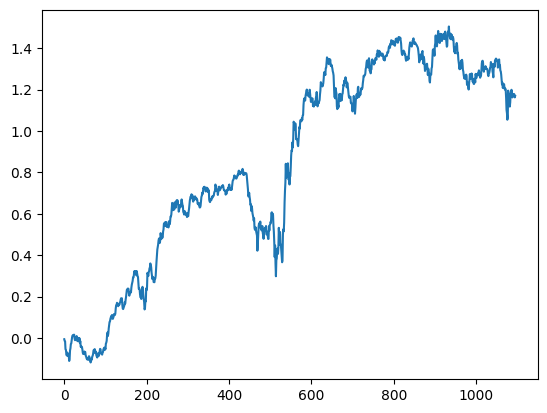

In [4]:
plt.plot((np.cumprod(pnl + 1) - 1))